# FORMULA 1 RACE PREDICTION MODEL

## Predicting race winners using XGRADIENT Boost

### Background

I am a huge motorsports fan, whether Formula 1, or Indycar, or endurance racing. So as someone wanting to improve my data skills it seems natural I should try and combine this with one of my favirote hobbies. For this project I found a really extensible [api](https://openf1.org/) that has a good mix of categorial and numerical data. We can query this api 


### The Model - XGradient Boost Reg:MSE

When first researching this I went through several models to determine what would be the best one to use in the given scenario. Since we have many parameters, from telemetry data on cars to historical driver data, I wanted a model that could handle mutliple data sets and still provide an accurate result. Something like binary classification or rank order modeling would not be well suited for this scenario. We have numeric data, sequential data, classification data etc. Since we want to show the predicted result as a real number we can use linear regression for this problem. 

I also wanted to choose a model that would improve over each iteration and be able to handle missing values if needed. With those criteria in mind using XGBoost seemed to make the most sense in this scenario. Now lets see if we can use this model to predict the race winner for a given session using variuos data points gathered. 

## Step 1: import packages
For this notebook we will use numpy, pandas, sklearn, xgboost, and seaborn for visualization.

In [1]:
import numpy as np
import pandas as pd
import io
import xgboost as xgb
import urllib3
from urllib.parse import urlencode, urlparse, parse_qs, urlunparse
from urllib3 import request
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Step 2: Get the data and shape it

Now that we have imported our packages we need to:

1. Load the csv data for weather, laps, drivers, stints, and pit stops.
2. Create necessary dataframes combining data and creating necessary perofrmance indicators.


For this example we are going to start with a single race just to better understand the model before we import data.
We will use the Spa-Francochamps Grand Prix from 2024 as our training data.

We ultimately want the final data frame to look like this:

| race_id | final_position | driver_id | track_name | avg_speed | fastest_lap | number_pit_stops | avg_engine_power | avg_pit_stop_time | avg_air_temp | avg_track_temp | avg_humidity |
|---------|---------------|-----------|------------|-----------|-------------|------------------|------------------|------------------|--------------|--------------|-------------|
|         |               |           |            |           |             |                  |                  |                  |              |              |             |


Once we have the data shaped then we can then start to define our training data and test data. 

To get the data there are several options:

1. Use data from [Kaggle](https://www.kaggle.com/)
2. Use an open source api [OpenF1](https://openf1.org/)

After further research I found some issues with option 1. Though Kaggle offers some pretty extensive CSV data sets for f1 historical data, its very limited in terms of telemetry data, weather and track conditions, and other important data. As a result, I think it would be best to use the openf1 API. The good news is that instead of using the generic JSON response the API allows us to use a search param csv?=True so that we can download as a csv file in our notebook.

In [54]:
# define our http pool manager
http = urllib3.PoolManager()

#define a function that allows us to stream the data from openf1 and perform calculations on larger data sets
def stream_data_for_calcs(http_data, chunk_size: int, avg_columns: list = None, *args) -> pd.DataFrame:
    if 'calculate_avg' in args:
        sum_columns = {col: 0 for col in avg_columns}
        count_columns = {col: 0 for col in avg_columns}

        # Process data in chunks so that we do not get failed api requests
        for chunk in pd.read_csv(io.StringIO(http_data.data.decode('utf-8')), chunksize=chunk_size):
            for col in avg_columns:
                if col in chunk.columns:
                    sum_columns[col] += chunk[col].sum()
                    count_columns[col] += chunk[col].count()

        # Compute final averages for each avg column provided
        avg_values = {f"avg_{col}": (sum_columns[col] / count_columns[col]) if count_columns[col] > 0 else 0 for col in avg_columns}

        df = pd.read_csv(io.StringIO(http_data.data.decode('utf-8')))
        # Insert into dataframe the new avg_columns
        for col, avg_value in avg_values.items():
            df[col] = avg_value

        return df
        

# define a function that allows us to update a url based on data from previous dataframes
def update_url_params(url:str, query_params:dict = None) -> str:

    initial_url = urlparse(url)
    current_params = parse_qs(initial_url.query)
    current_params.update(query_params)

    final_queries = urlencode(current_params, doseq=True)
    return urlunparse(initial_url._replace(query=final_queries))
    
# define a function that intakes url and returns in csv format
def get_data(url: str, add_params: dict, stream_data:bool = False, avg_columns: list = None, **kwargs) -> pd.DataFrame:

    if add_params:
        url = update_url_params(url, add_params)

    http_response: urllib3.http.HttpResonse = http.request('GET', url)

    if http_response.status != 200:
        raise RuntimeError(
            f"Request failed with status code {http_response.status}.\n"
            f"Response body: {http_response.data.decode('utf-8')}"
        )

    try:
        if stream_data:
             streamed_df = stream_data_for_calcs(http_response,1000, avg_columns,'calculate_avg')
             return streamed_df.rename(columns=kwargs)[list(kwargs.values())] if kwargs else streamed_df
        else:
            df = pd.read_csv(io.StringIO(http_response.data.decode('utf-8')))
           # return renamed column df else return default df
            return df.rename(columns=kwargs)[list(kwargs.values())] if kwargs else df

    except Exception as e:
        raise RuntimeError(f"❌ Failed to parse CSV data: {e}")
        
# get the race id from this api request, we can store the different request urls here so we can query by key value in later cells
urls={"race_and_track":"https://api.openf1.org/v1/sessions?country_name=Belgium&year=2024&csv=true", 
      "driver_ids":"https://api.openf1.org/v1/drivers?csv=true", "race_weather":"https://api.openf1.org/v1/weather?csv=true",
     "lap_data":"https://api.openf1.org/v1/laps?csv=true", "telemetry_data":"https://api.openf1.org/v1/car_data?csv=true", "pit_stop_data":
      "https://api.openf1.org/v1/pit?csv=true", "results":"https://api.openf1.org/v1/position?csv=true", "stints":"https://api.openf1.org/v1/stints?csv=true"}

#get track data for race_id and track name
track = get_data(urls["race_and_track"], add_params={"session_type":"Race"}, session_key="race_id", location="track")
#print out the dataframe for track info
track
#now we can get the weather data for that race

,race_id,track
0,9574,Spa-Francorchamps


Next we want to get some pertinent weather data such as the average air temperature, average track temperature, and other weather data that could be useful for predictions of driver performance.


In [4]:
#get weather query
session_key = track["race_id"]
track_weather = get_data(urls["race_weather"], add_params={"session_key":session_key})
#track_weather
#get average air_temperature, avg_track_temp, avg_humidity
track_weather = track_weather.assign(
    avg_air_temp=track_weather["air_temperature"].mean(),
    avg_track_temp=track_weather["track_temperature"].mean(),
    avg_humidity=track_weather["humidity"].mean())
track_weather_final = track_weather[["avg_air_temp","avg_track_temp","avg_humidity"]].iloc[:1]
#final weather dataframe
track_weather_final

#combine weather and track info

track_data_frame = track.merge(track_weather_final, how="cross")
track_data_frame

,race_id,track,avg_air_temp,avg_track_temp,avg_humidity
0,9574,Spa-Francorchamps,21.327407,42.257778,49.622222


Great, now we have basic track data including weather! Next we need to start collecting our driver data.

In [5]:
#Now that we have our track data we can make an api request to get all the drivers that were in that specific race
session_key = track["race_id"]
drivers_df = get_data(urls["driver_ids"],add_params={"session_key": session_key}, driver_number="driver_id", broadcast_name="driver_name", team_name="team_name")

#final driver dataframe
final_df = drivers_df.merge(track_data_frame, how="cross")
final_df


,driver_id,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity
0,1,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
1,2,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
2,3,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
3,4,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
4,10,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
5,11,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
6,14,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
7,16,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
8,18,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
9,20,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222


The next step is to combine these two data frames so we have an inital dataframe we can use to add average performances, weather, and other data.
First lets get the telemetry data for each driver during the race. For this we want to calculate:

1. Average speed (km/h)
2. Fastest lap (seconds)


In [6]:
# get driver numbers
driver_numbers = set(drivers_df['driver_id'])

# iterate through each driver and calculate their average lap time
lap_data = get_data(urls['lap_data'], add_params={"session_key":session_key}).rename(columns={"driver_number":"driver_id"})
avg_lap_time = lap_data.groupby("driver_id").agg(avg_lap_duration=("lap_duration","mean"), max_speed=("st_speed","max")).reset_index()

final_df_lap = avg_lap_time.merge(final_df, on="driver_id", how="right")
final_df_lap

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222


Great, now that we have the average laps and fastest speed from each driver lets add in some more granular telemetry data.This will include:
1. avg_throttle(engine power)
2. avg_rpm(revolutions per minute)


In [7]:
# since there is a large data set size (close to 30,000 rows per driver), we are going to chunk and stream the data as we calculate the 
# avg engine power and avg_rpm
#url: str, add_params: dict, stream_data:bool = False, avg_columns: list = None, **kwargs
#we will define a method that will handle the data streamed from the api and also calculate our averages per driver
all_telem_data=[]
for driver in driver_numbers:
    telemetry_data = get_data(urls["telemetry_data"],
                              add_params={"session_key":session_key, "driver_number":driver}, 
                              stream_data=True, avg_columns=["throttle","rpm"]).rename(columns={"driver_number":"driver_id"})
    avg_df = telemetry_data[["driver_id","avg_throttle","avg_rpm"]].groupby("driver_id").mean().reset_index()
    all_telem_data.append(avg_df)
concacted_telemetry_data = pd.concat(all_telem_data, ignore_index=False)
final_data_with_telem = final_df_lap.merge(concacted_telemetry_data, on="driver_id", how="left")
final_data_with_telem

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.271514,7118.456939
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.037056,7046.875589
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,51.991202,7074.098113
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.570635,7053.451142
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.726905,6960.218322


Next we need to get the number of pit stops per driver and calculate the average pit stop time in seconds. So the next data frame will return
1.pit_stops
2.avg_pit_stop_time

In [8]:
#request data for pit stops
pit_stops = get_data(urls["pit_stop_data"], add_params={"session_key":session_key}).rename(columns={"driver_number":"driver_id"})

driver_avg_pit_stops = pit_stops.groupby("driver_id").agg(avg_pit_duration=("pit_duration","mean"), pit_stops=("driver_id", "size")).reset_index()
final_data_with_pit_stops = final_data_with_telem.merge(driver_avg_pit_stops, on="driver_id", how="left")
final_data_with_pit_stops

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0


Finally, we can query and get the final position for each driver to determine how they finsihed the race. We will make a new column named:
1. driver_result

Once we have this data we can start setting up our model!

In [9]:
race_results = get_data(urls["results"], add_params={"session_key":session_key}).rename(columns={"driver_number":"driver_id", "position":"result"})
final_result = race_results[["driver_id","result"]].groupby("driver_id").last().reset_index()
final_data_frame = final_data_with_pit_stops.merge(final_result, on="driver_id", how="left")
final_data_frame

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0,8
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0,9
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0,4
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0,12
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0,15


Now we have our final data set! We have some training data we can use now and we can start modeling the data.


# Step 3: Model the data

Now that we have a data set we can use we can start working with our xgboost model. We are going to use the following model with XGBOOST with regression.

Why should we use XGBOOST?

1. We need to use a model that can be used for ranking order, not binary classificaiton, or some other problem set.
2. We have a mix of data types, numneric and categorical.
3. Xgboost allows us to use regression modeling so we can predict the driver positions in the final results.

Given these constraints this model seems to be a good selection to model our data. 

Now we can start to set up our training data and run the model.



In [10]:
#First, lets make sure we still have the final data_frame
final_data_frame.head()

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14


Okay so we have our data. First, we need to encode our categorical data. In this case we need to encode the track, team_name, and driver_name so they have a numerical representation.


In [11]:
label_encoder = LabelEncoder()
final_data_frame["track"] = label_encoder.fit_transform(final_data_frame["track"])
final_data_frame["team_name"] = label_encoder.fit_transform(final_data_frame["team_name"])
final_data_frame["driver_name"] = label_encoder.fit_transform(final_data_frame["driver_name"])

final_data_frame

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result
0,1,109.099619,319.0,13,8,9574,0,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5
1,2,110.795643,320.0,11,9,9574,0,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19
2,3,110.119881,316.0,3,7,9574,0,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11
3,4,109.151667,322.0,10,5,9574,0,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6
4,10,110.414098,324.0,16,0,9574,0,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14
5,11,110.049881,315.0,17,8,9574,0,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0,8
6,14,110.056143,317.0,5,1,9574,0,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0,9
7,16,109.205143,316.0,1,2,9574,0,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0,4
8,18,110.344707,315.0,12,1,9574,0,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0,12
9,20,110.412634,318.0,8,3,9574,0,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0,15


Perfect, our categorical data has been properly encoded and now we can define our features and outcomes.

In [199]:
#these are the features we want to later have part of the DMatrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming final_data_frame is your DataFrame
# Preprocess the data
features = ["avg_lap_duration", "max_speed", "avg_air_temp", "avg_track_temp", 
            "avg_humidity", "avg_throttle", "avg_rpm", "avg_pit_duration", "pit_stops"]
X = final_data_frame[features]
y = final_data_frame["result"]

# Handle missing values
X = X.fillna(X.mean())  # or use other strategies like interpolation, etc.
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the XGBoost model, in this case I am using squarederror
xg_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=100, n_estimators=50, learing_rate=0.5, random_state=42)
xg_model.fit(X_train_scaled, y_train)

# Predict result for all drivers from the dataset 
X_scaled = scaler.transform(X)
final_data_frame['predicted_result'] = np.round(xg_model.predict(X_scaled))

# Display the results in a new dataframe
predicted_results = final_data_frame[['driver_id', 'race_id', 'predicted_result', 'result']]
predicted_results

,driver_id,race_id,predicted_result,result
0,1,9574,3.0,5
1,2,9574,14.0,19
2,3,9574,11.0,11
3,4,9574,6.0,6
4,10,9574,14.0,14
5,11,9574,8.0,8
6,14,9574,9.0,9
7,16,9574,4.0,4
8,18,9574,12.0,12
9,20,9574,15.0,15


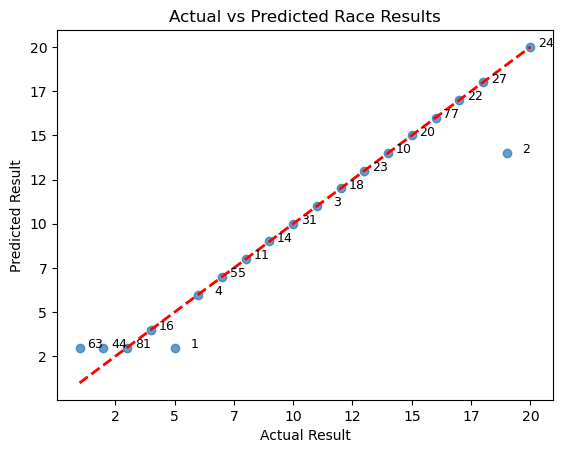

In [42]:
import warnings
warnings.filterwarnings('ignore')

plt.scatter(final_data_frame['result'], final_data_frame['predicted_result'], alpha=0.7)
plt.plot([min(final_data_frame['result']), max(final_data_frame['result'])],
         [min(final_data_frame['result']), max(final_data_frame['result'])], 'r--', lw=2)
plt.xlabel('Actual Result')
plt.ylabel('Predicted Result')
ax = plt.gca()  # Get current axis for x,y
current_ticks = ax.get_xticks()
current_y_ticks = ax.get_yticks()
# Convert current tick positions to integer instead of the decimal place so we can have better readability
new_tick_labels = [int(tick) for tick in current_ticks]
new_tick_y_labels = [int(tick) for tick in current_y_ticks]
# Set the new tick labels
ax.set_xticklabels(new_tick_labels)
ax.set_yticklabels(new_tick_labels)

#add driver_id to plot
for i, row in final_data_frame.iterrows():
    plt.text(row['result'] + 1.0, row['predicted_result'], int(row['driver_id']), fontsize=9, ha='right')

plt.title('Actual vs Predicted Race Results')
plt.show()

# Observations
So we have run the model and predicted the race outcomes and compared it to the actual results. How did our model do?
Well we can see that for the majority of the drivers our model predicted their results fairly well. However we have four outliers who do not follow our function. Can we gain insight into these outliers?

The first thing we can do is calculate the MAE(mean absolute error) so we can get the average difference between the precited and actual results and evaulate if we have high baisis or variance in our data. 

In [46]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
# Predict on training and test data
y_train_pred = np.round(xg_model.predict(X_train_scaled))
y_test_pred = np.round(xg_model.predict(X_test_scaled))

# Compute MAE for training and test data
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Predict results for all data
X_scaled = scaler.transform(X)
final_data_frame['predicted_result'] = np.round(xg_model.predict(X_scaled))

# Compute MAE for the full dataset (actual results vs predictions)
mae_actual = mean_absolute_error(final_data_frame["result"], final_data_frame["predicted_result"])

# Display MAE results
print(f"MAE on Training Data: {mae_train:.4f}")
print(f"MAE on Test Data: {mae_test:.4f}")
print(f"MAE on Full Dataset (Actual vs Predicted): {mae_actual:.4f}")


MAE on Training Data: 0.0000
MAE on Test Data: 2.5000
MAE on Full Dataset (Actual vs Predicted): 0.5000


Okay so we can see that our MAE is 2.5 on our test data which ideally we would want to get lower, I would at least like a MAE of 1.0-1.5. The MAE on the full data set however is 0.5 which is good, as its indicating our model is generally 0.5 places off from the actual result of each driver. Given the numerous amount of variables within a formula 1 race this is actually pretty good for a first model run. However, the training data MAE is 0.0 which is a big red flag for overfitting. This needs to be addressed to have more confidence in the model. There could be other factors that could affect our accuracy.

1. The data set only used one race for our training data and did not include other key features like qualifiying times. 
2. We had a limited amount of features, perhaps we could add more quantatative features?
3. Are there any categorical features we could add, can we create any?
4. Is there a different model we could use?

## Add new features and create weight for qualifying times. 
One path to improving our model is to add a weight based off the qualifying position of for each driver. Based on that we will have the lowest qualifying position (i.e. place 1 which is the highest score in reality) be the max value. We can then add this weight to our model to better weigh the results for each driver. 

In [112]:
#lets query the api for qualifying times. Luckily we can just add another query param to the session endpoint like we did earlier and get the qualifying results

qualifying_session = track = get_data(urls["race_and_track"], add_params={"session_type":"Qualifying"}, session_key="race_id", location="track") 
qualifying_session_id = qualifying_session["race_id"]

quali_results = get_data(urls["results"], add_params={"session_key":qualifying_session_id}).rename(columns={"driver_number":"driver_id", "position":"quali_result"})
final_quali_result = quali_results[["driver_id","quali_result"]].groupby("driver_id").last().reset_index()
final_quali_result

,driver_id,quali_result
0,1,1
1,2,19
2,3,13
3,4,5
4,10,12
5,11,3
6,14,9
7,16,2
8,18,15
9,20,17


In [113]:
#Great, now lets merge those results into our final_data_frame

final_data_with_qualifying = final_data_frame.merge(final_quali_result, on="driver_id", how="left")
final_data_with_qualifying

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result,predicted_result,quali_result
0,1,109.099619,319.0,13,8,9574,0,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5,5.0,1
1,2,110.795643,320.0,11,9,9574,0,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19,16.0,19
2,3,110.119881,316.0,3,7,9574,0,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11,11.0,13
3,4,109.151667,322.0,10,5,9574,0,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6,6.0,5
4,10,110.414098,324.0,16,0,9574,0,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14,14.0,12
5,11,110.049881,315.0,17,8,9574,0,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0,8,8.0,3
6,14,110.056143,317.0,5,1,9574,0,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0,9,9.0,9
7,16,109.205143,316.0,1,2,9574,0,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0,4,4.0,2
8,18,110.344707,315.0,12,1,9574,0,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0,12,12.0,15
9,20,110.412634,318.0,8,3,9574,0,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0,15,15.0,17


Okay so we have our qualifying data now in the dataframe. As we previously mentioned, our MAE score for the training data indicates we are overfitting the model. We want to make sure we address this so that our model is more accurate. We can do the following to help alleviate the overfitting. 

1. Use regularization. To do this we add the parameters lambda_ and alpha, which correspond to L2 and L1 normalization respectively. L2 normalization essentially adds a penalty to the model so that in each iteration the model has smaller weights so no one feature does not dominate the various iterations. L1 normalization is used to help ensure only the most relevant features are used which helps generalize the model better.
2. We reduced the max_depth and n_estimators for the model. The max_depth was initially too high, greatly contributing to overfitting so reducing this to 5, 1 scalar value below the default, seemed to improve accuracy and reduce overfitting. Also reducing the n_estimators, or the number of trees, also helped solve some of the overfitting in the training data. I think the previous amount increased the variance in the model so it was difficult to achieve generalization.
3. Increasing randomness in each tree. To achieve this we used the parameters subsample and cosample_bytree. subsample ensures that we do not use the entire dataset in each tree making sure it becomes more generalized and avoid data memorization. cosample_bytree ensures we have more randomness in each tree by randomly selecting features to use so that we are better able to achieve generalization and ensure trees are not as correlated to one another. 

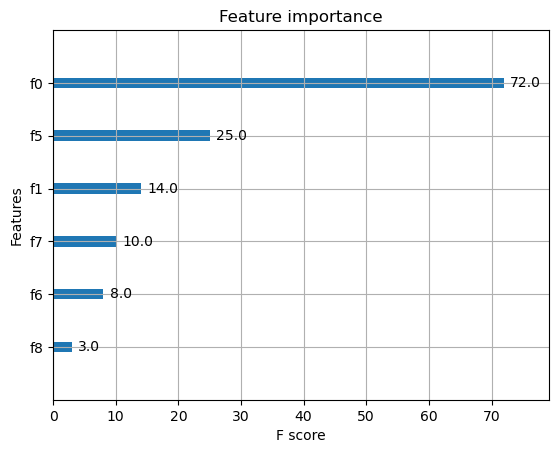

In [205]:
#define qualifying positions weights
from sklearn.preprocessing import MinMaxScaler
X_train_indices = X_train.index
quali_times_weights = final_data_with_qualifying.loc[X_train_indices, 'quali_result']
weights = 21 - quali_times_weights
X = final_data_with_qualifying[features]
y = final_data_with_qualifying["result"]

# Handle missing values
X = X.fillna(X.mean())  # or use other strategies like interpolation, etc.
y = y.fillna(y.mean())

# Make predictions on all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scaler features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the XGBoost model, in this case I am using squarederror
xg_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3, 
    n_estimators=30,  
    learning_rate=0.1,  
    lambda_=1.0,  
    alpha=0.5,  
    subsample=0.8,  
    colsample_bytree=0.8, #This ensures each tree uses different feature sets so that the model is more genrazlized. 
    random_state=42,
)

xg_model.fit(X_train_scaled, y_train)

# Predict result for all drivers from the dataset 
X_scaled = scaler.transform(X)
final_data_with_qualifying['predicted_result'] = np.round(xg_model.predict(X_scaled))

# Display the results in a new dataframe
predicted_results = final_data_with_qualifying[['driver_id', 'race_id', 'predicted_result', 'result']]
predicted_results



Okay so we can see some diffrent results in our output so lets plot it out so its easier to see. We should also see if we improved our MAE. This time we should compare both the MAE for test and training data.


In [206]:
# Predict on training and test data
y_train_pred = np.round(xg_model.predict(X_train_scaled))
y_test_pred = np.round(xg_model.predict(X_test_scaled))

# Compute MAE for training and test data
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Predict results for all data
X_scaled = scaler.transform(X)
final_data_frame['predicted_result'] = np.round(xg_model.predict(X_scaled))

# Compute MAE for the full dataset (actual results vs predictions)
mae_actual = mean_absolute_error(final_data_frame["result"], final_data_frame["predicted_result"])

# Display MAE results
print(f"MAE on Training Data: {mae_train:.4f}")
print(f"MAE on Test Data: {mae_test:.4f}")
print(f"MAE on Full Dataset (Actual vs Predicted): {mae_actual:.4f}")

MAE on Training Data: 0.7222
MAE on Test Data: 2.5000
MAE on Full Dataset (Actual vs Predicted): 0.9000


Adding qualifying time to the data set did make a slight imporvement in the MAE for the test and full dataset. We also see that the MAE for the trainig data increased to .7 which is better than 0! The test data MAE though is still too high. This indicates we are still overfitting the test data and will need to address this. 

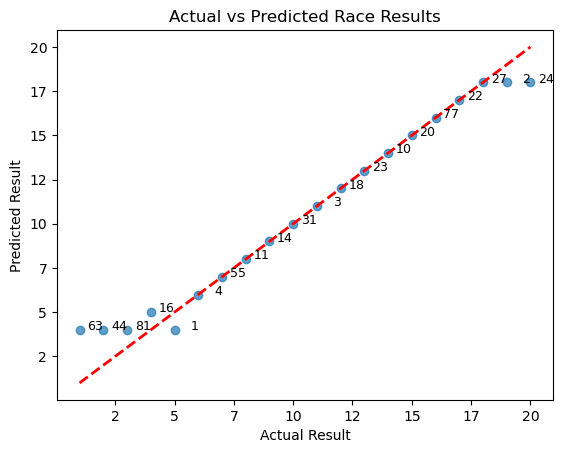

In [177]:
import warnings
warnings.filterwarnings('ignore')

plt.scatter(predicted_results['result'], predicted_results['predicted_result'], alpha=0.7)
plt.plot([min(predicted_results['result']), max(predicted_results['result'])],
         [min(predicted_results['result']), max(predicted_results['result'])], 'r--', lw=2)
plt.xlabel('Actual Result')
plt.ylabel('Predicted Result')
ax = plt.gca()  # Get current axis for x,y
current_ticks = ax.get_xticks()
current_y_ticks = ax.get_yticks()
# Convert current tick positions to integer instead of the decimal place so we can have better readability
new_tick_labels = [int(tick) for tick in current_ticks]
new_tick_y_labels = [int(tick) for tick in current_y_ticks]
# Set the new tick labels
ax.set_xticklabels(new_tick_labels)
ax.set_yticklabels(new_tick_labels)

#add driver_id to plot
for i, row in predicted_results.iterrows():
    plt.text(row['result'] + 1.0, row['predicted_result'], int(row['driver_id']), fontsize=9, ha='right')

plt.title('Actual vs Predicted Race Results')
plt.show()

Now we can see that the model is making predicitons closer to their actual qualifying results. If we look at driver 63, we can see that he qualified in 7th place and was predicted to finsih in 5th given other factors such as his average lap time etc. But if we look into the actual events of the race we can see that the driver in question, George Russell, has some interesting data points that we could use to maybe get the model to actually match his result of finishing in first(he was later disqualified post race but he actually won it on track). We also notice that driver 1 has actually moved to be on the identity line indicating a better model for his paticular data. Driver number 2 also moved closer to the identity line though they are still underpredicted. Lets look further at the data for driver 63. 

1. Driver 63 only had one pit stop during the entire race. Compare that to driver 11 who qualified in 3rd place but had three pit stops total for the race and finished in 7th place.
2. Driver 63 also only used two tire compounds, MEDIUM and HARD, compared to other drivers who used all tired compounds available and had more pit stops.
3. The team that driver 63 belongs to, Mercedes, were both podium finishers. 


So to address this I think it would be a good idea to update the model to account for the tire compounds and encode that data to be used in the model. Another piece of data we can add is team results from the previous races in the year, which could help account for team strategies and other factors outside the direct control of the drivers. 

In [74]:
#first, lets query the api with the stints endpoint and get our tire compound data
tire_compounds = get_data(urls["stints"], add_params={"session_key":session_key}).rename(columns={"compound":"tire_compound", "driver_number":"driver_id"})
tire_compounds[["tire_compound","driver_id"]]

tire_compounds_sorted = tire_compounds.sort_values(by=['driver_id']).reset_index(drop=True)
tire_compounds_sorted["num_compounds_used"] = tire_compounds_sorted.groupby("driver_id")['tire_compound'].transform(lambda x: x.nunique())
tire_compounds_final = tire_compounds_sorted.groupby("driver_id").agg(
    tire_compounds=('tire_compound', lambda x: list(x.unique())),
    num_compounds_used=('num_compounds_used', 'first')
).reset_index()

tire_compounds_final

,driver_id,tire_compounds,num_compounds_used
0,1,"[MEDIUM, HARD]",2
1,2,"[HARD, MEDIUM]",2
2,3,"[SOFT, HARD, MEDIUM]",3
3,4,"[HARD, MEDIUM]",2
4,10,"[HARD, MEDIUM]",2
5,11,"[MEDIUM, SOFT, HARD]",3
6,14,"[MEDIUM, HARD]",2
7,16,"[MEDIUM, HARD]",2
8,18,"[HARD, MEDIUM]",2
9,20,"[HARD, MEDIUM]",2


In [71]:
#now that we have the number of tire compounds used and which tire compounds per driver lets join this to the final data frame.
final_data_with_tired_compounds = final_data_with_qualifying.merge(tire_compounds_final, on="driver_id", how="left")
final_data_with_tired_compounds

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result,predicted_result,quali_result,tire_compounds,compounds_used
0,1,109.099619,319.0,13,8,9574,0,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5,5.0,1,"[MEDIUM, HARD]",2
1,2,110.795643,320.0,11,9,9574,0,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19,16.0,19,"[HARD, MEDIUM]",2
2,3,110.119881,316.0,3,7,9574,0,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11,11.0,13,"[SOFT, HARD, MEDIUM]",3
3,4,109.151667,322.0,10,5,9574,0,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6,6.0,5,"[HARD, MEDIUM]",2
4,10,110.414098,324.0,16,0,9574,0,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14,14.0,12,"[HARD, MEDIUM]",2
5,11,110.049881,315.0,17,8,9574,0,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0,8,8.0,3,"[MEDIUM, SOFT, HARD]",3
6,14,110.056143,317.0,5,1,9574,0,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0,9,9.0,9,"[MEDIUM, HARD]",2
7,16,109.205143,316.0,1,2,9574,0,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0,4,4.0,2,"[MEDIUM, HARD]",2
8,18,110.344707,315.0,12,1,9574,0,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0,12,12.0,15,"[HARD, MEDIUM]",2
9,20,110.412634,318.0,8,3,9574,0,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0,15,15.0,17,"[HARD, MEDIUM]",2


Now that we have the tire compounds used by each driver, and the number of unique tire compounds used in the race, lets get the previous results for the teams for that season. Unfortuantely this data is not available via openf1 so I needed to use a csv file downloaded from Kaggle to get that historical data. 

In [83]:
#in this codeblock we will read from the races.csv and get all races for the 2024 season
races_kaggle_df = pd.read_csv("races.csv")
races_kaggle_df_2024 = races_kaggle_df[races_kaggle_df["year"] == 2024]
races_kaggle_df_2024

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1101,1121,2024,1,3,Bahrain Grand Prix,2024-03-02,15:00:00,https://en.wikipedia.org/wiki/2024_Bahrain_Gra...,2024-02-29,11:30:00,2024-02-29,15:00:00,2024-03-01,12:30:00,2024-03-01,16:00:00,\N,\N
1102,1122,2024,2,77,Saudi Arabian Grand Prix,2024-03-09,17:00:00,https://en.wikipedia.org/wiki/2024_Saudi_Arabi...,2024-03-07,13:30:00,2024-03-07,17:00:00,2024-03-08,13:30:00,2024-03-08,17:00:00,\N,\N
1103,1123,2024,3,1,Australian Grand Prix,2024-03-24,04:00:00,https://en.wikipedia.org/wiki/2024_Australian_...,2024-03-22,01:30:00,2024-03-22,05:00:00,2024-03-23,01:30:00,2024-03-23,05:00:00,\N,\N
1104,1124,2024,4,22,Japanese Grand Prix,2024-04-07,05:00:00,https://en.wikipedia.org/wiki/2024_Japanese_Gr...,2024-04-05,02:30:00,2024-04-05,06:00:00,2024-04-06,02:30:00,2024-04-06,06:00:00,\N,\N
1105,1125,2024,5,17,Chinese Grand Prix,2024-04-21,07:00:00,https://en.wikipedia.org/wiki/2024_Chinese_Gra...,2024-04-19,03:30:00,2024-04-19,07:30:00,\N,\N,2024-04-20,07:00:00,2024-04-20,03:00:00
1106,1126,2024,6,79,Miami Grand Prix,2024-05-05,20:00:00,https://en.wikipedia.org/wiki/2024_Miami_Grand...,2024-05-03,16:30:00,2024-05-03,20:30:00,\N,\N,2024-05-04,20:00:00,2024-05-04,16:00:00
1107,1127,2024,7,21,Emilia Romagna Grand Prix,2024-05-19,13:00:00,https://en.wikipedia.org/wiki/2024_Emilia_Roma...,2024-05-17,11:30:00,2024-05-17,15:00:00,2024-05-18,10:30:00,2024-05-18,14:00:00,\N,\N
1108,1128,2024,8,6,Monaco Grand Prix,2024-05-26,13:00:00,https://en.wikipedia.org/wiki/2024_Monaco_Gran...,2024-05-24,11:30:00,2024-05-24,15:00:00,2024-05-25,10:30:00,2024-05-25,14:00:00,\N,\N
1109,1129,2024,9,7,Canadian Grand Prix,2024-06-09,18:00:00,https://en.wikipedia.org/wiki/2024_Canadian_Gr...,2024-06-07,17:30:00,2024-06-07,21:00:00,2024-06-08,16:30:00,2024-06-08,20:00:00,\N,\N
1110,1130,2024,10,4,Spanish Grand Prix,2024-06-23,13:00:00,https://en.wikipedia.org/wiki/2024_Spanish_Gra...,2024-06-21,11:30:00,2024-06-21,15:00:00,2024-06-22,10:30:00,2024-06-22,14:00:00,\N,\N


In [107]:
# now that we have the races for the 2024 season lets get the constructors and their results from the season. Then we will need to assocaite this with our dataframe
# using the data from the Openf1 api
constructors_kaggle_df = pd.read_csv("constructors.csv").rename(columns={"constructorId":"constructor_id"})
constructors_kaggle_df

,constructor_id,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
...,...,...,...,...,...
207,210,haas,Haas F1 Team,American,http://en.wikipedia.org/wiki/Haas_F1_Team
208,211,racing_point,Racing Point,British,http://en.wikipedia.org/wiki/Racing_Point_F1_Team
209,213,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri
210,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team


In [109]:
# Now that we have our constructors we are going to use fuzzy searching to match them to the records from the drivers dataframe from the openf1 api. 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

#define helper function to use process method

def team_name_best_match(team_name, constructor_names):
     match = process.extract(team_name, constructor_names, limit=1)
     return match[0][0] if match else None

constructor_names = constructors_kaggle_df["name"].to_list()


drivers_df["matched_constructor"] = drivers_df["team_name"].apply(lambda x: team_name_best_match(x, constructor_names))

drivers_combined_constructor_id_df = drivers_df.merge(constructors_kaggle_df[["name","constructor_id"]], left_on='matched_constructor', right_on='name', how='left')
drivers_combined_constructor_id_df[["driver_id","constructor_id"]]
                                                                  

,driver_id,constructor_id
0,1,9
1,2,3
2,3,215
3,4,1
4,10,214
5,11,9
6,14,117
7,16,6
8,18,117
9,20,210
